In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, io
import spacy
import string

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
twcs_df = pd.read_csv('twcs/twcs.csv')

In [3]:
twcs_df.shape

(2811774, 7)

In [4]:
twcs_df.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')

Columns Meaning

tweet_id
The unique ID for this tweet

author_id
The unqiue ID for this tweet author (anonymized for non-company users)

inbound
Whether or not the tweet was sent (inbound) to a company

created_at
When the tweet was created

text
The text content of the tweet

In [5]:
# We'll focus on what customers said to us, so let's get only customer messages
customer_msg = twcs_df[twcs_df.inbound]
customer_msg.shape

(1537843, 7)

In [6]:
# Original dataset includes support data from multiple companies. Here we choose one company with similar business as ours.
# for example AmazonHelp.
customer_msg = customer_msg[customer_msg['text'].str.contains("AppleSupport")]
customer_msg.shape

(97153, 7)

In [7]:
# Let's take a look at the data
customer_msg.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
397,697,115854,True,Tue Oct 31 22:31:23 +0000 2017,@AppleSupport The newest update. I️ made sure ...,699,696.0
399,698,115854,True,Tue Oct 31 22:17:40 +0000 2017,@AppleSupport https://t.co/NV0yucs0lB,696,700.0
400,700,115854,True,Tue Oct 31 22:16:56 +0000 2017,@AppleSupport why are my I️’s changing not sho...,698,NaN
402,702,115855,True,Tue Oct 31 22:11:31 +0000 2017,@AppleSupport Tried resetting my settings .. r...,701,703.0
404,704,115855,True,Tue Oct 31 21:59:17 +0000 2017,@AppleSupport This is what it looks like https...,703,705.0


In [8]:
# Let us clean the tweet text for better visualization
customer_msg = customer_msg[~customer_msg['text'].isnull()]

customer_msg.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
397,697,115854,True,Tue Oct 31 22:31:23 +0000 2017,@AppleSupport The newest update. I️ made sure ...,699,696.0
399,698,115854,True,Tue Oct 31 22:17:40 +0000 2017,@AppleSupport https://t.co/NV0yucs0lB,696,700.0
400,700,115854,True,Tue Oct 31 22:16:56 +0000 2017,@AppleSupport why are my I️’s changing not sho...,698,NaN
402,702,115855,True,Tue Oct 31 22:11:31 +0000 2017,@AppleSupport Tried resetting my settings .. r...,701,703.0
404,704,115855,True,Tue Oct 31 21:59:17 +0000 2017,@AppleSupport This is what it looks like https...,703,705.0


In [9]:
def preprocess(CleanText):
    CleanText = CleanText.str.replace("(<br/>)", "", regex=True)
    CleanText = CleanText.str.replace('(<a).*(>).*(</a>)', '', regex=True)
    CleanText = CleanText.str.replace('(&amp)', '', regex=True)
    CleanText = CleanText.str.replace('(&gt)', '', regex=True)
    CleanText = CleanText.str.replace('(&lt)', '', regex=True)
    CleanText = CleanText.str.replace('(\xa0)', ' ', regex=True) 
    CleanText = CleanText.str.lower()  
    return CleanText

customer_msg['text'] = preprocess(customer_msg['text'])

In [10]:
customer_msg.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
397,697,115854,True,Tue Oct 31 22:31:23 +0000 2017,@applesupport the newest update. i️ made sure ...,699,696.0
399,698,115854,True,Tue Oct 31 22:17:40 +0000 2017,@applesupport https://t.co/nv0yucs0lb,696,700.0
400,700,115854,True,Tue Oct 31 22:16:56 +0000 2017,@applesupport why are my i️’s changing not sho...,698,NaN
402,702,115855,True,Tue Oct 31 22:11:31 +0000 2017,@applesupport tried resetting my settings .. r...,701,703.0
404,704,115855,True,Tue Oct 31 21:59:17 +0000 2017,@applesupport this is what it looks like https...,703,705.0


In [11]:
# Pre processing the tweets by performing stemming and lemmatization using nltk
stopword = stopwords.words('english')
def preprocess_tweets(customer_msg):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for tweets in customer_msg['text']:
        words = [w for w in word_tokenize(tweets) if (w not in stopword)]
        
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_tweets(customer_msg)

In [12]:
corpus_sentence = [[' '.join(i)] for i in corpus]
customer_msg = pd.DataFrame(corpus_sentence, columns=['teks'])
customer_msg.head(25)


,teks
0,applesupport newest update made sure download ...
1,applesupport http //t.co/nv0yucs0lb
2,applesupport changing showing correctly social...
3,applesupport tried resetting setting restartin...
4,applesupport look like http //t.co/xcqu2l4xub
5,applesupport iphone plus yes
6,applesupport need answer annoying
7,applesupport sent
8,hey applesupport anyone else upgraded ios11.1 ...
9,applesupport happening ... http //t.co/x3szsjxfat


In [13]:
sid = SentimentIntensityAnalyzer()

In [14]:
customer_msg['scores'] = customer_msg['teks'].apply(lambda text: sid.polarity_scores(str(text)))

customer_msg.head()

,teks,scores
0,applesupport newest update made sure download ...,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp..."
1,applesupport http //t.co/nv0yucs0lb,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,applesupport changing showing correctly social...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,applesupport tried resetting setting restartin...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,applesupport look like http //t.co/xcqu2l4xub,"{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp..."


In [15]:
customer_msg['compound']  = customer_msg['scores'].apply(lambda score_dict: score_dict['compound'])

customer_msg.head()

,teks,scores,compound
0,applesupport newest update made sure download ...,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp...",0.3182
1,applesupport http //t.co/nv0yucs0lb,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,applesupport changing showing correctly social...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,applesupport tried resetting setting restartin...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,applesupport look like http //t.co/xcqu2l4xub,"{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp...",0.3612


In [16]:
#customer_msg['comp_score'] = customer_msg['compound'].apply(lambda c: 'positive' if c >=0.1 else ('negative' if c<=-0.1 else 'neutral'))
customer_msg['comp_score'] = customer_msg['compound'].apply(lambda c: 'positive' if c >=0.03 else 'negative')
customer_msg.head()

,teks,scores,compound,comp_score
0,applesupport newest update made sure download ...,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp...",0.3182,positive
1,applesupport http //t.co/nv0yucs0lb,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative
2,applesupport changing showing correctly social...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative
3,applesupport tried resetting setting restartin...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative
4,applesupport look like http //t.co/xcqu2l4xub,"{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp...",0.3612,positive


In [17]:
customer_msg['comp_score'].value_counts()

negative    63800
positive    33353
Name: comp_score, dtype: int64

<AxesSubplot:ylabel='comp_score'>

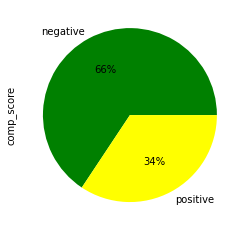

In [18]:
customer_msg['comp_score'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["green", "yellow", "red"])

In [19]:
customer_msg.drop(['scores', 'compound'], axis=1, inplace=True)

In [20]:
customer_msg.head()

,teks,comp_score
0,applesupport newest update made sure download ...,positive
1,applesupport http //t.co/nv0yucs0lb,negative
2,applesupport changing showing correctly social...,negative
3,applesupport tried resetting setting restartin...,negative
4,applesupport look like http //t.co/xcqu2l4xub,positive


In [21]:
#customer_msg.comp_score = customer_msg.comp_score.replace({'positive': 1, 'neutral':0, 'negative': -1})
customer_msg.comp_score = customer_msg.comp_score.replace({'positive': 1, 'negative': 0})

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow

In [23]:
train, test = train_test_split(customer_msg, test_size=0.1, random_state=44)


In [41]:
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (87437, 2)
Test dataset shape: (9716, 2)


In [42]:
train_texts = pd.concat([train['teks']],axis=0).astype("str")
test_texts = pd.concat([test['teks']],axis=0).astype("str")

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = 50

In [44]:
print('Vocab size : ', vocab_size)

Vocab size :  48706


In [45]:
sequences_train = tokenizer.texts_to_sequences(train_texts) 
sequences_test = tokenizer.texts_to_sequences(test_texts) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.comp_score.values
y_test = test.comp_score.values

In [46]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('glove.6B.100d.txt', encoding="utf-8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [47]:
print('Embedding Matrix Generating...')
print('Embedding Matrix Shape -> ', embeddings_matrix.shape)

Embedding Matrix Generating...
Embedding Matrix Shape ->  (48706, 100)


In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [50]:
# build a model
model =  keras.models.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           4870600   
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [51]:
optimizer = Adam(lr=3e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

c:\Users\anne\anaconda3\envs\text-mining\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
2733/2733 [==============================] - 227s 83ms/step - loss: 0.4135 - accuracy: 0.8122 - val_loss: 0.3388 - val_accuracy: 0.8538
Epoch 2/20
2733/2733 [==============================] - 203s 74ms/step - loss: 0.3347 - accuracy: 0.8555 - val_loss: 0.2956 - val_accuracy: 0.8749
Epoch 3/20
2733/2733 [==============================] - 215s 79ms/step - loss: 0.2991 - accuracy: 0.8735 - val_loss: 0.2542 - val_accuracy: 0.8983
Epoch 4/20
2733/2733 [==============================] - 209s 77ms/step - loss: 0.2735 - accuracy: 0.8869 - val_loss: 0.2330 - val_accuracy: 0.9055
Epoch 5/20
2733/2733 [==============================] - 210s 77ms/step - loss: 0.2565 - accuracy: 0.8939 - val_loss: 0.2221 - val_accuracy: 0.9109
Epoch 6/20
2733/2733 [==============================] - 210s 77ms/step - loss: 0.2378 - accuracy: 0.9033 - val_loss: 0.2085 - val_accuracy: 0.9182
Epoch 7/20
2733/2733 [==============================] - 185s 68ms/step - loss: 0.2228 - accuracy: 0.9102 - val_loss: 0

In [56]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

304/304 [==============================] - 13s 21ms/step


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6367
           1       0.94      0.91      0.93      3349

    accuracy                           0.95      9716
   macro avg       0.95      0.94      0.94      9716
weighted avg       0.95      0.95      0.95      9716



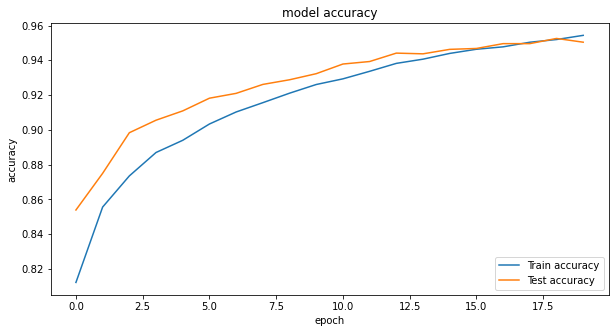

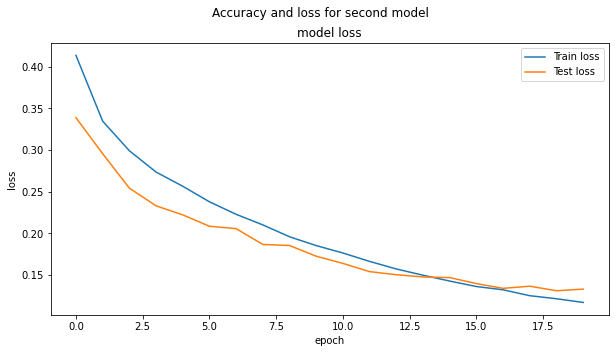

In [58]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()